In [ ]:
from pyspark.sql.functions import count, desc, struct
"""
Finds the most popular Pinterest category people post to based on their country.

Parameters:
- df_pin: DataFrame containing Pinterest post data
- df_geo: DataFrame containing geographical information

Returns:
- df_most_popular_category_by_country: DataFrame with columns 'country', 'category', and 'category_count'
"""
df_most_popular_category_by_country = df_pin.join(df_geo, on='ind') \
       .groupBy('country', 'category') \
       .agg(count('*').alias('count')) \
       .groupBy('country') \
       .agg(max(struct('count', 'category')).alias('max_count')) \
       .select('country', 'max_count.category', 'max_count.count') \
       .withColumnRenamed("count", "category_count")

df_most_popular_category_by_country.show()

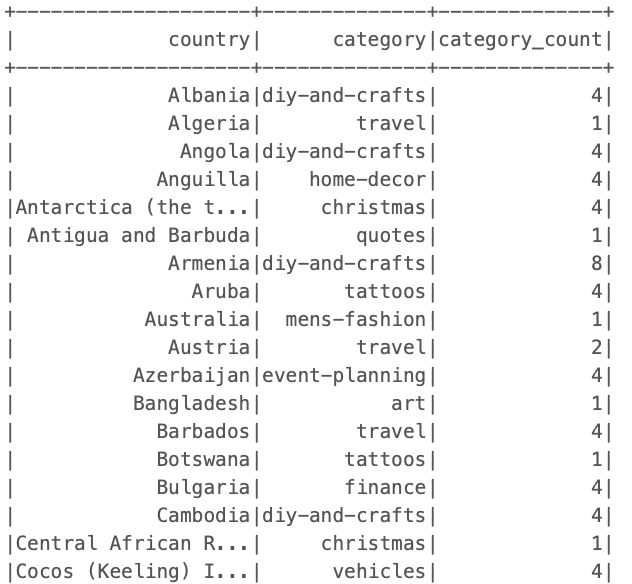

In [ ]:
"""
Process the most popular category by year.

Parameters:
- df_pin: DataFrame, the DataFrame containing Pinterest data.
- df_geo: DataFrame, the DataFrame containing geographical data.

Returns:
- df_most_popular_category_by_year: DataFrame, the processed DataFrame with the most popular category by year.
"""
from pyspark.sql.functions import year

# Join df_pin with df_geo on the 'ind' column and filter by timestamp range
df_most_popular_category_by_year = df_pin.join(df_geo, on='ind') \
    .filter((year('timestamp') >= 2018) & (year('timestamp') <= 2022))
# Group by year and category, and count the number of occurrences
df_most_popular_category_by_year = df_most_popular_category_by_year.groupBy(year('timestamp').alias('post_year'), 'category') \
       .agg(count('*').alias('category_count'))
# Find the most popular category for each year
df_most_popular_category_by_year = df_most_popular_category_by_year.orderBy(['post_year', 'category_count'], ascending=[True, False]) \
    .groupBy('post_year') \
    .agg({'category': 'first', 'category_count': 'first'}) \
    .withColumnRenamed('first(category)', 'category') \
    .withColumnRenamed('first(category_count)', 'category_count')
# Show the result
df_most_popular_category_by_year.show()

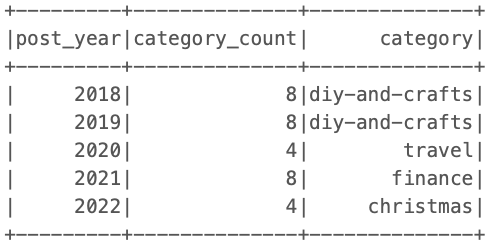

In [ ]:
"""
Find the user with the most followers in each country and the country with the user having the most followers.

Parameters:
- df_pin (DataFrame): DataFrame containing user data with follower counts.
- df_geo (DataFrame): DataFrame containing geographical information, including country data.

Returns:
- df_most_followers_by_country (DataFrame): DataFrame showing the user with the most followers in each country.
- df_most_followers_country (DataFrame): DataFrame showing the country with the user having the most followers.
"""
from pyspark.sql.functions import max, rank
from pyspark.sql.window import Window

# Find the user with the most followers in each country
df_most_followers_by_country = df_pin.join(df_geo, on='ind') \
    .groupBy('country', 'poster_name') \
    .agg(max('follower_count')) \
    .withColumn('rank', rank().over(Window.partitionBy('country').orderBy(desc('max(follower_count)')))) \
    .filter('rank = 1') \
    .select('country', 'poster_name', 'max(follower_count)') \
    .withColumnRenamed('max(follower_count)', 'follower_count')

df_most_followers_by_country.show()

# Find the country with the user that has the most followers
df_most_followers_country = df_most_followers_by_country.groupBy('country') \
      .agg(max('follower_count').alias('follower_count')) \
      .orderBy(desc('follower_count')) \
      .limit(1) \
      .select('country', 'follower_count')

df_most_followers_country.show()

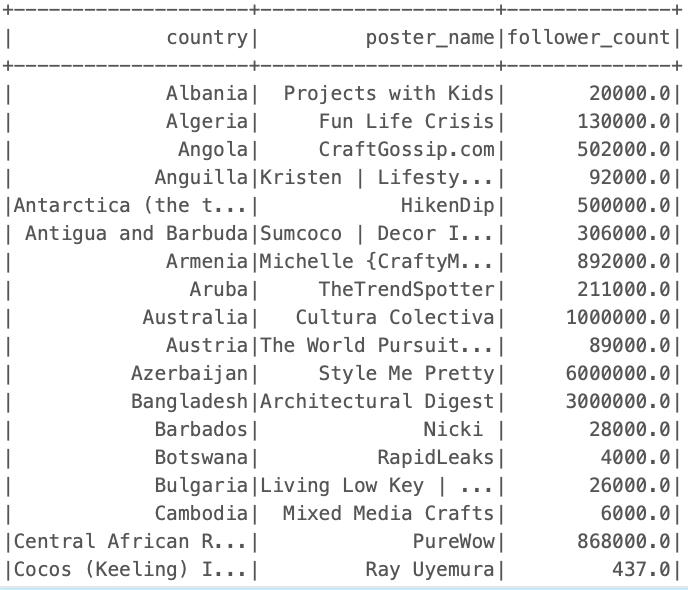

In [ ]:

"""
Process and analyze data from df_pin and df_user DataFrames.

Steps:
1. Join df_pin and df_user on the 'ind' column.
2. Create a new column 'age_group' based on the age ranges.
3. Group by 'age_group' and 'category' columns.
4. Calculate the count of posts in each category for each age group.
5. Find the most popular category in each age group.
6. Display the results.

Parameters:
- df_pin (DataFrame): DataFrame containing pin data.
- df_user (DataFrame): DataFrame containing user data.

Returns:
- DataFrame: Resulting DataFrame with age group, most popular category, and category count.
"""
from pyspark.sql.functions import when

# Join the df_pin and df_user on the ind column and create a new column 'age_group' based on the age ranges
df_user_with_age_group = df_pin.join(df_user, on="ind") \
    .withColumn("age_group", 
                when(df_user.age.between(18, 24), "18-24")
                .when(df_user.age.between(25, 35), "25-35")
                .when(df_user.age.between(36, 50), "36-50")
                .when(df_user.age > 50, "+50")
                .otherwise("Unknown"))
# Group by 'age_group' and 'category' columns, calculate the count of posts in each category for each age group and find the most popular category
df_category_count_by_age = df_user_with_age_group.groupBy("age_group", "category") \
    .agg(count("*").alias("category_count")) \
    .groupBy("age_group") \
    .agg(max(struct("category_count", "category")).alias("max_count")) \
    .select("age_group", "max_count.category", "max_count.category_count") \
# Show the results
df_category_count_by_age.show()

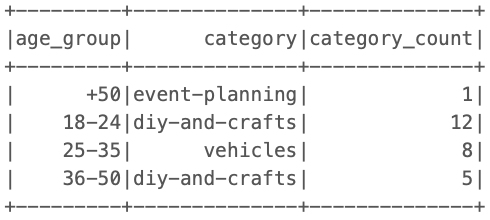

In [ ]:
"""
Calculates the median follower count for each age group in the provided DataFrame.

Parameters:
- df_user_with_age_group (pyspark.sql.DataFrame): DataFrame containing user data with age groups.

Returns:
- df_median_follower_count_by_age (pyspark.sql.DataFrame): DataFrame with columns 'age_group' and 'median_follower_count'.
"""
from pyspark.sql.functions import percentile_approx

df_median_follower_count_by_age = df_user_with_age_group.groupBy("age_group") \
    .agg(percentile_approx("follower_count", 0.5, lit(1000000)).alias("median_follower_count")) \
    .select("age_group", "median_follower_count")

df_median_follower_count_by_age.show()

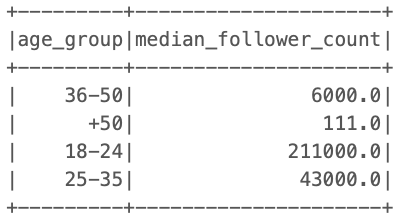

In [ ]:
"""
Process user data to count the number of users who joined each year between 2015 and 2020.

Parameters:
- df_user (DataFrame): DataFrame containing user data.
- df_geo (DataFrame): DataFrame containing geographic data.

Returns:
- DataFrame: Processed DataFrame with columns 'post_year' and 'number_users_joined'.
"""
from pyspark.sql.functions import year, count

df_user_geo_joined = df_user.join(df_geo, on='ind') \
    .select(year('timestamp').alias('post_year'), 'date_joined') \
    .where("year(timestamp) between 2015 and 2020")

df_users_joined_by_year = df_user_geo_joined.groupBy("post_year") \
    .agg(count("*").alias("number_users_joined"))

df_users_joined_by_year.show()

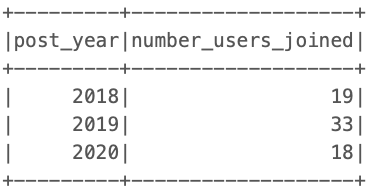

In [ ]:
"""
Process data to calculate the median follower count for each year.

Args:
- df_user: DataFrame containing user data.
- df_geo: DataFrame containing geographical data.
- df_pin: DataFrame containing Pinterest data.

Returns:
- df_median_followers_by_post_year: DataFrame with calculated median follower count for each year.
"""
# filter users who joined between 2015 and 2020
df_user_joined = df_user.filter(df_user.date_joined.between('2015-01-01', '2020-12-31'))
# extract the year from the timestamp column in the df_geo table
df_geo_year = df_geo.withColumn("post_year", year("timestamp"))
# join df_user_joined with df_geo_year and df_pin to get follower count for each user
df_join_pin = (
    df_user_joined
    .join(df_geo_year, on="ind")
    .join(df_pin, on="ind")
)
# calculate the median follower count for each year
df_median_followers_by_post_year = (
    df_join_pin
    .groupBy("post_year")
    .agg(percentile_approx("follower_count", 0.5, lit(1000000))
         .alias("median_follower_count"))
)
# display the results
df_median_followers_by_post_year.show()

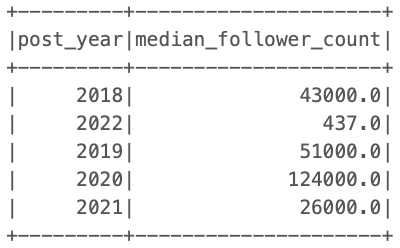

In [ ]:
"""
Filters users who joined between 2015 and 2020, joins necessary dataframes, and calculates the median follower count
by age group and post year.

Parameters:
- df_user (DataFrame): DataFrame containing user data.
- df_pin (DataFrame): DataFrame containing Pinterest data.
- df_geo (DataFrame): DataFrame containing geographical data.
- df_user_with_age_group (DataFrame): DataFrame containing user data with age groups.

Returns:
- DataFrame: Resulting DataFrame with columns 'age_group', 'post_year', and 'median_follower_count'.
"""
# Filter users joined between 2015 and 2020
df_user_filtered = df_user.filter((df_user.date_joined >= "2015-01-01") & (df_user.date_joined < "2021-01-01"))
# Join the required dataframes
df_join2 = df_pin.join(df_user_filtered, on = "ind").join(df_geo.select("ind", year("timestamp").alias("post_year")), on="ind").join(df_user_with_age_group.select("age_group", "ind"), on="ind")
# Calculate the median follower count by age group and post year
df_median_follower_by_year_joined = df_join2.groupBy("age_group", "post_year").agg(percentile_approx("follower_count", 0.5, lit(1000000)).alias("median_follower_count"))
# Print the results
df_median_follower_by_year_joined.show()

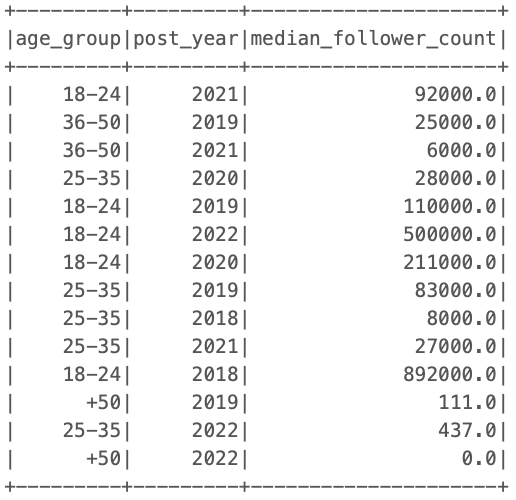